# Classic

In [1]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss
import os

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
# Training parameters
DATASET_PATH = 'data/data_gen_original.npz' #'datasets/dataset_57M.npz'
# BATCH_SIZE = 8
# NUM_WORKERS = 0
# LR = 2e-4
# EPOCHS = 30

# # Model parameters
# d_model = 64 # Lattent dim
# q = 8 # Query size
# v = 8 # Value size
# h = 8 # Number of heads
# N = 4 # Number of encoder and decoder to stack
# attention_size = 12 # Attention window size
# dropout = 0.2 # Dropout rate
# pe = None # Positional encoding
# chunk_mode = None

# d_input = 27 # From dataset
# d_output = 8 # From dataset

BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 37 # From dataset
d_output = 8 # From dataset


In [3]:
torch.cuda.is_available()

True

In [4]:
# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Training

### Load dataset

In [5]:
ozeDataset = OzeDataset(DATASET_PATH)
# ozeDatasetLength = len(ozeDataset)

In [13]:
ozeDataset[7499]

(tensor([[0.5000, 0.5000, 0.0000,  ..., 0.9630, 0.4286, 0.0000],
         [0.5000, 0.5000, 0.0000,  ..., 0.9630, 0.4286, 0.0000],
         [0.5000, 0.5000, 0.0000,  ..., 0.9630, 0.4286, 0.0000],
         ...,
         [0.0000, 1.0000, 0.0000,  ..., 0.9630, 0.4286, 0.0000],
         [0.0000, 1.0000, 0.0000,  ..., 0.9630, 0.4286, 0.0000],
         [0.0000, 1.0000, 0.0000,  ..., 0.9630, 0.4286, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6250],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6242],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6226],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6931],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7112],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7249]]))

In [6]:
len(ozeDataset[0]), ozeDataset[0][0].shape, ozeDataset[0][1].shape

(2, torch.Size([672, 37]), torch.Size([672, 8]))

In [7]:
dataset_train, dataset_val, dataset_test = random_split(ozeDataset, (5500, 1000, 1000))
# dataset_train, dataset_val, dataset_test = random_split(ozeDataset, (trainSize, valSize, testSize))
# dataset_train, dataset_val, dataset_test = random_split(ozeDataset, (38000, 1000, 1000))

dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS
                           )

dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

In [8]:
for a, b in dataloader_val:
    break

In [9]:
a.shape, b.shape

(torch.Size([8, 672, 37]), torch.Size([8, 672, 8]))

### Load network

In [15]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe=pe).to('cuda')
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = OZELoss(alpha=0.3)

In [16]:
d_input, d_model, d_output, q, v, h, N, attention_size

(37, 64, 8, 8, 8, 8, 4, 12)

In [12]:
x.shape, y.shape

NameError: name 'x' is not defined

In [17]:
ozeDataset._x.shape, ozeDataset._y.shape

(torch.Size([7500, 672, 37]), torch.Size([7500, 672, 8]))

### Train

In [18]:
model_save_path

'models/model_2021_01_17__231351.pth'

In [15]:
! ls models

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


[Epoch  30/30]: 100%|██████████| 5500/5500 [02:45<00:00, 33.17it/s, loss=0.000695, val_loss=0.000873]


model exported to models/model_2021_01_17__232405.pth with loss 0.000740


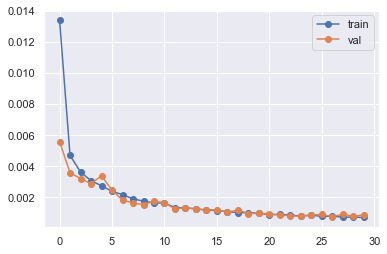

In [19]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to('cuda'))

            # Compute loss
            loss = loss_function(y.to('cuda'), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, 'cuda').item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

[Epoch  30/30]: 100%|██████████| 5500/5500 [02:34<00:00, 35.63it/s, loss=0.000447, val_loss=0.000499]


model exported to models/model_2021_01_18__004627.pth with loss 0.000499


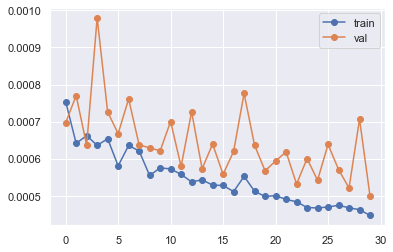

In [20]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

## Validation

In [22]:
_ = net.eval()

### Evaluate on the test dataset

In [23]:
netout.shape

torch.Size([4, 672, 8])

In [24]:
print(idx_prediction, idx_prediction+x.shape[0])

NameError: name 'idx_prediction' is not defined

In [21]:
predictions.shape, netout.shape, x.shape

NameError: name 'predictions' is not defined

In [54]:
predictions[0].shape

(168, 8)

In [56]:
predictions[10:15].shape

(5, 168, 8)

In [25]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 672, 8))
# predictions = np.empty(shape=(len(dataloader_test.dataset), 168, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to('cuda')).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 125/125 [00:14<00:00,  8.69it/s]


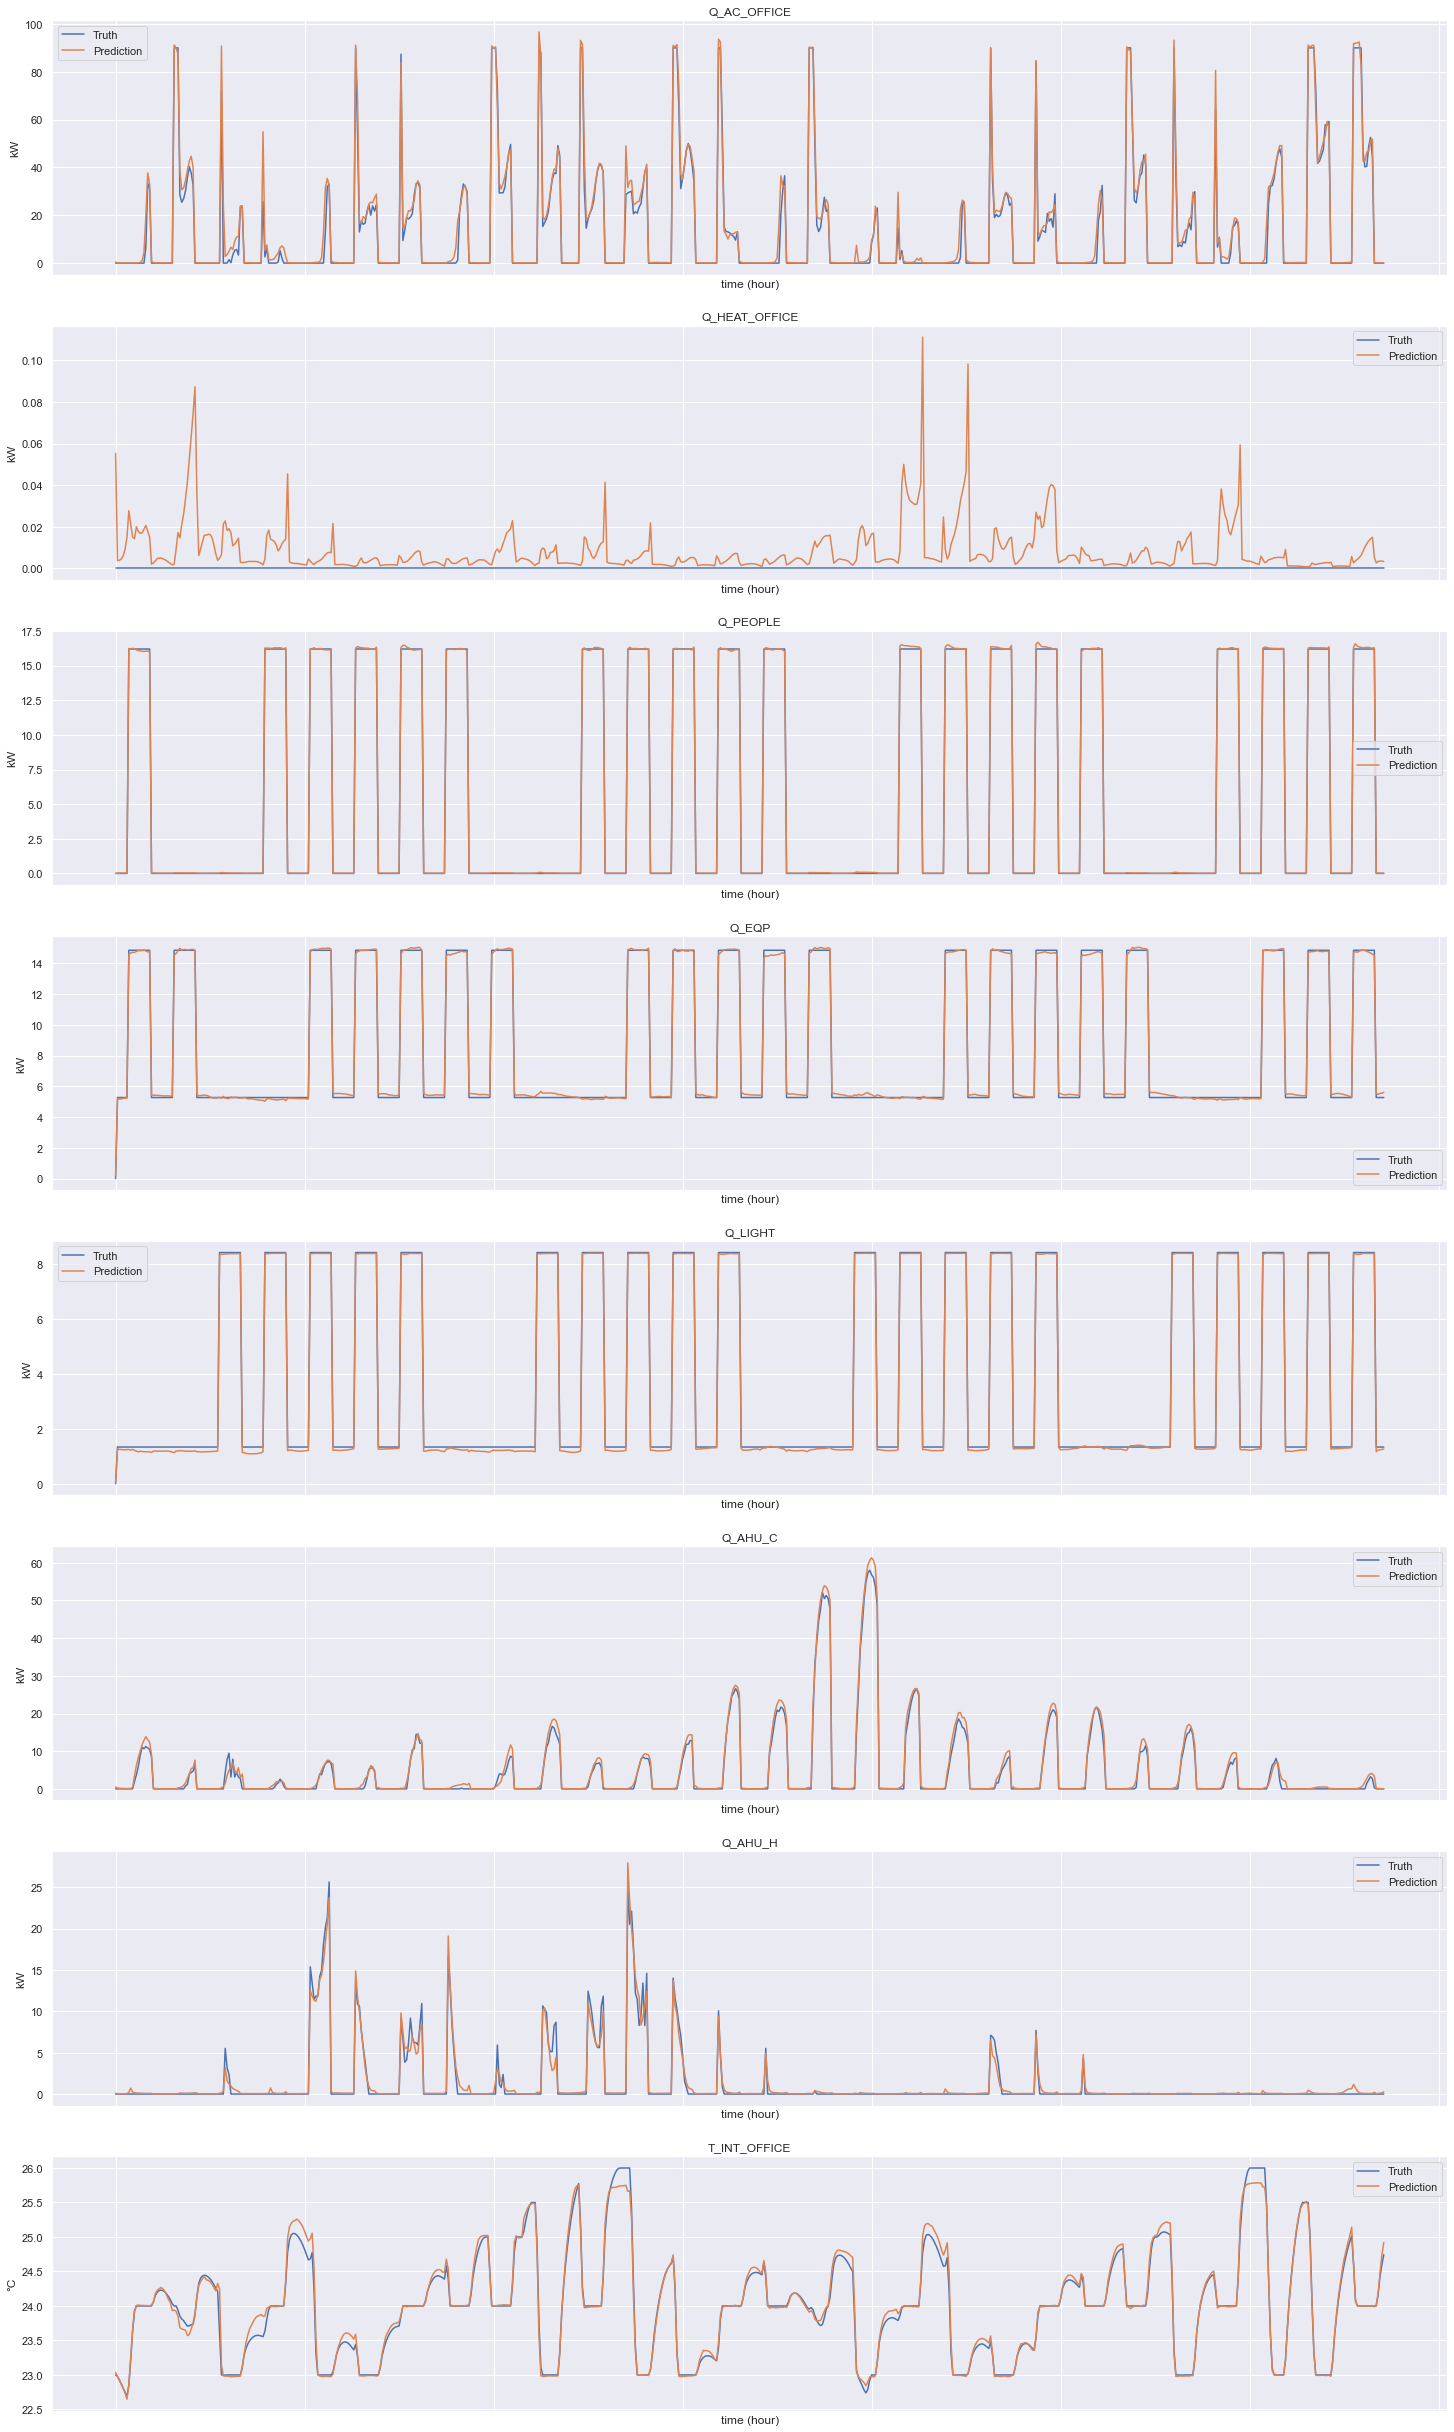

In [26]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

### Plot results on a sample

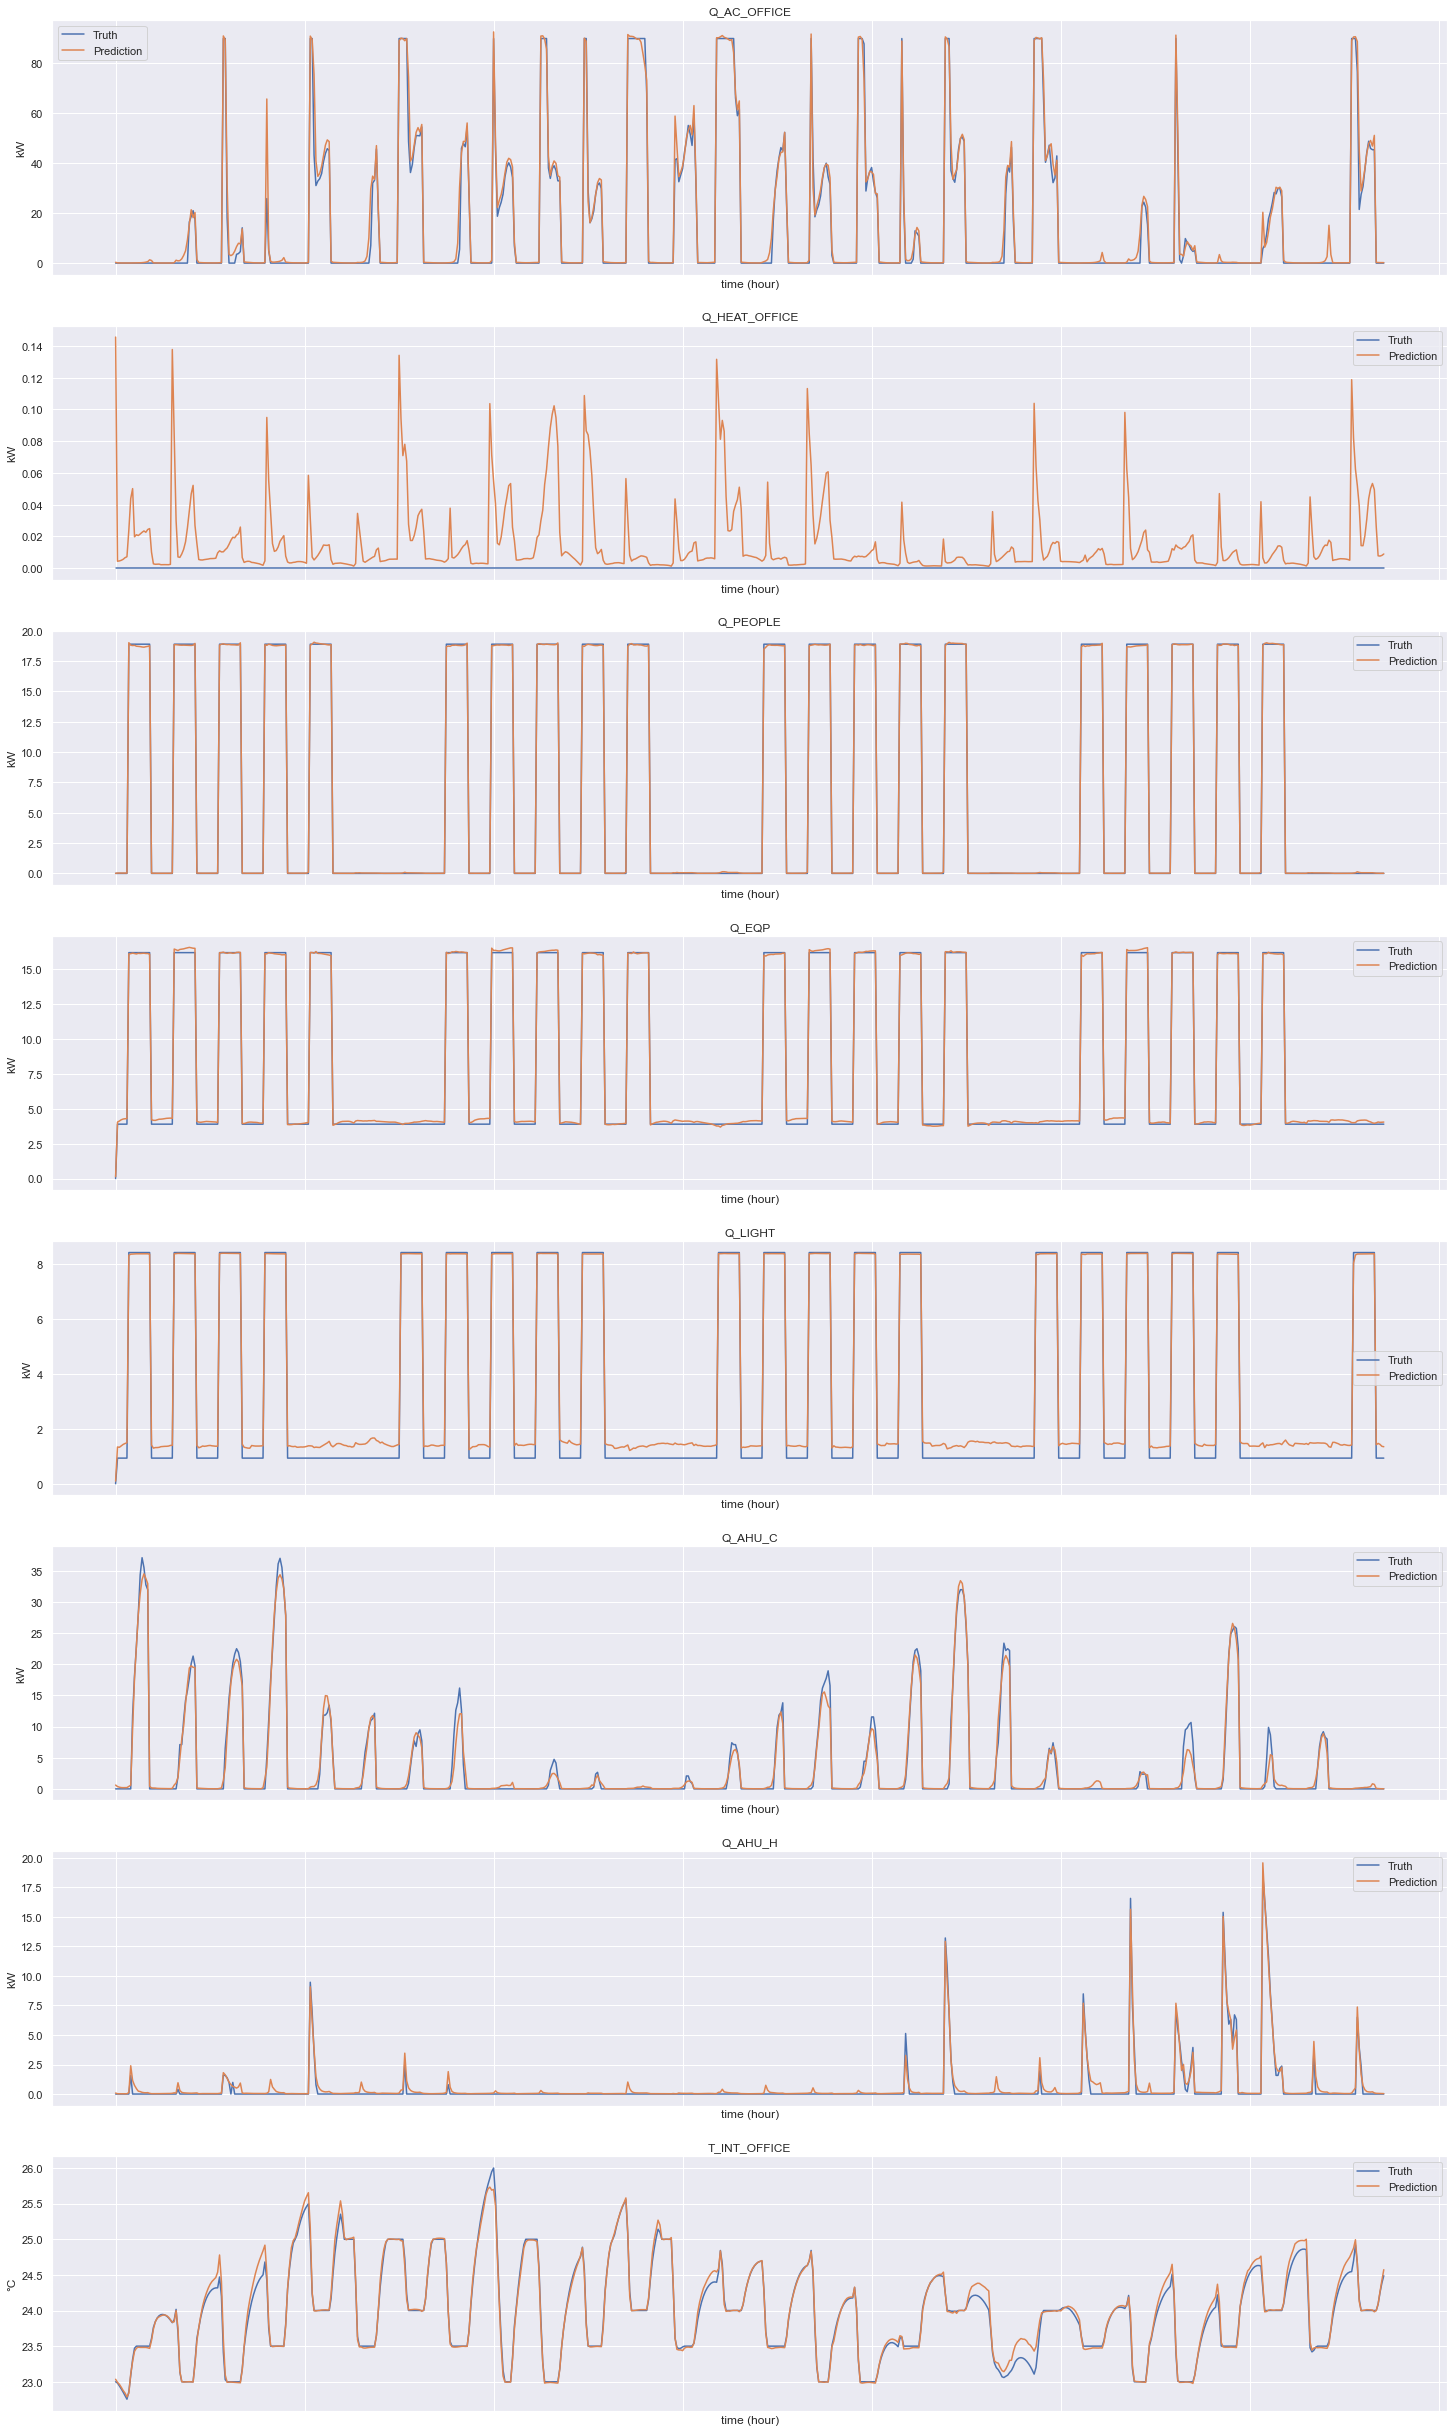

In [27]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

### Plot error distributions

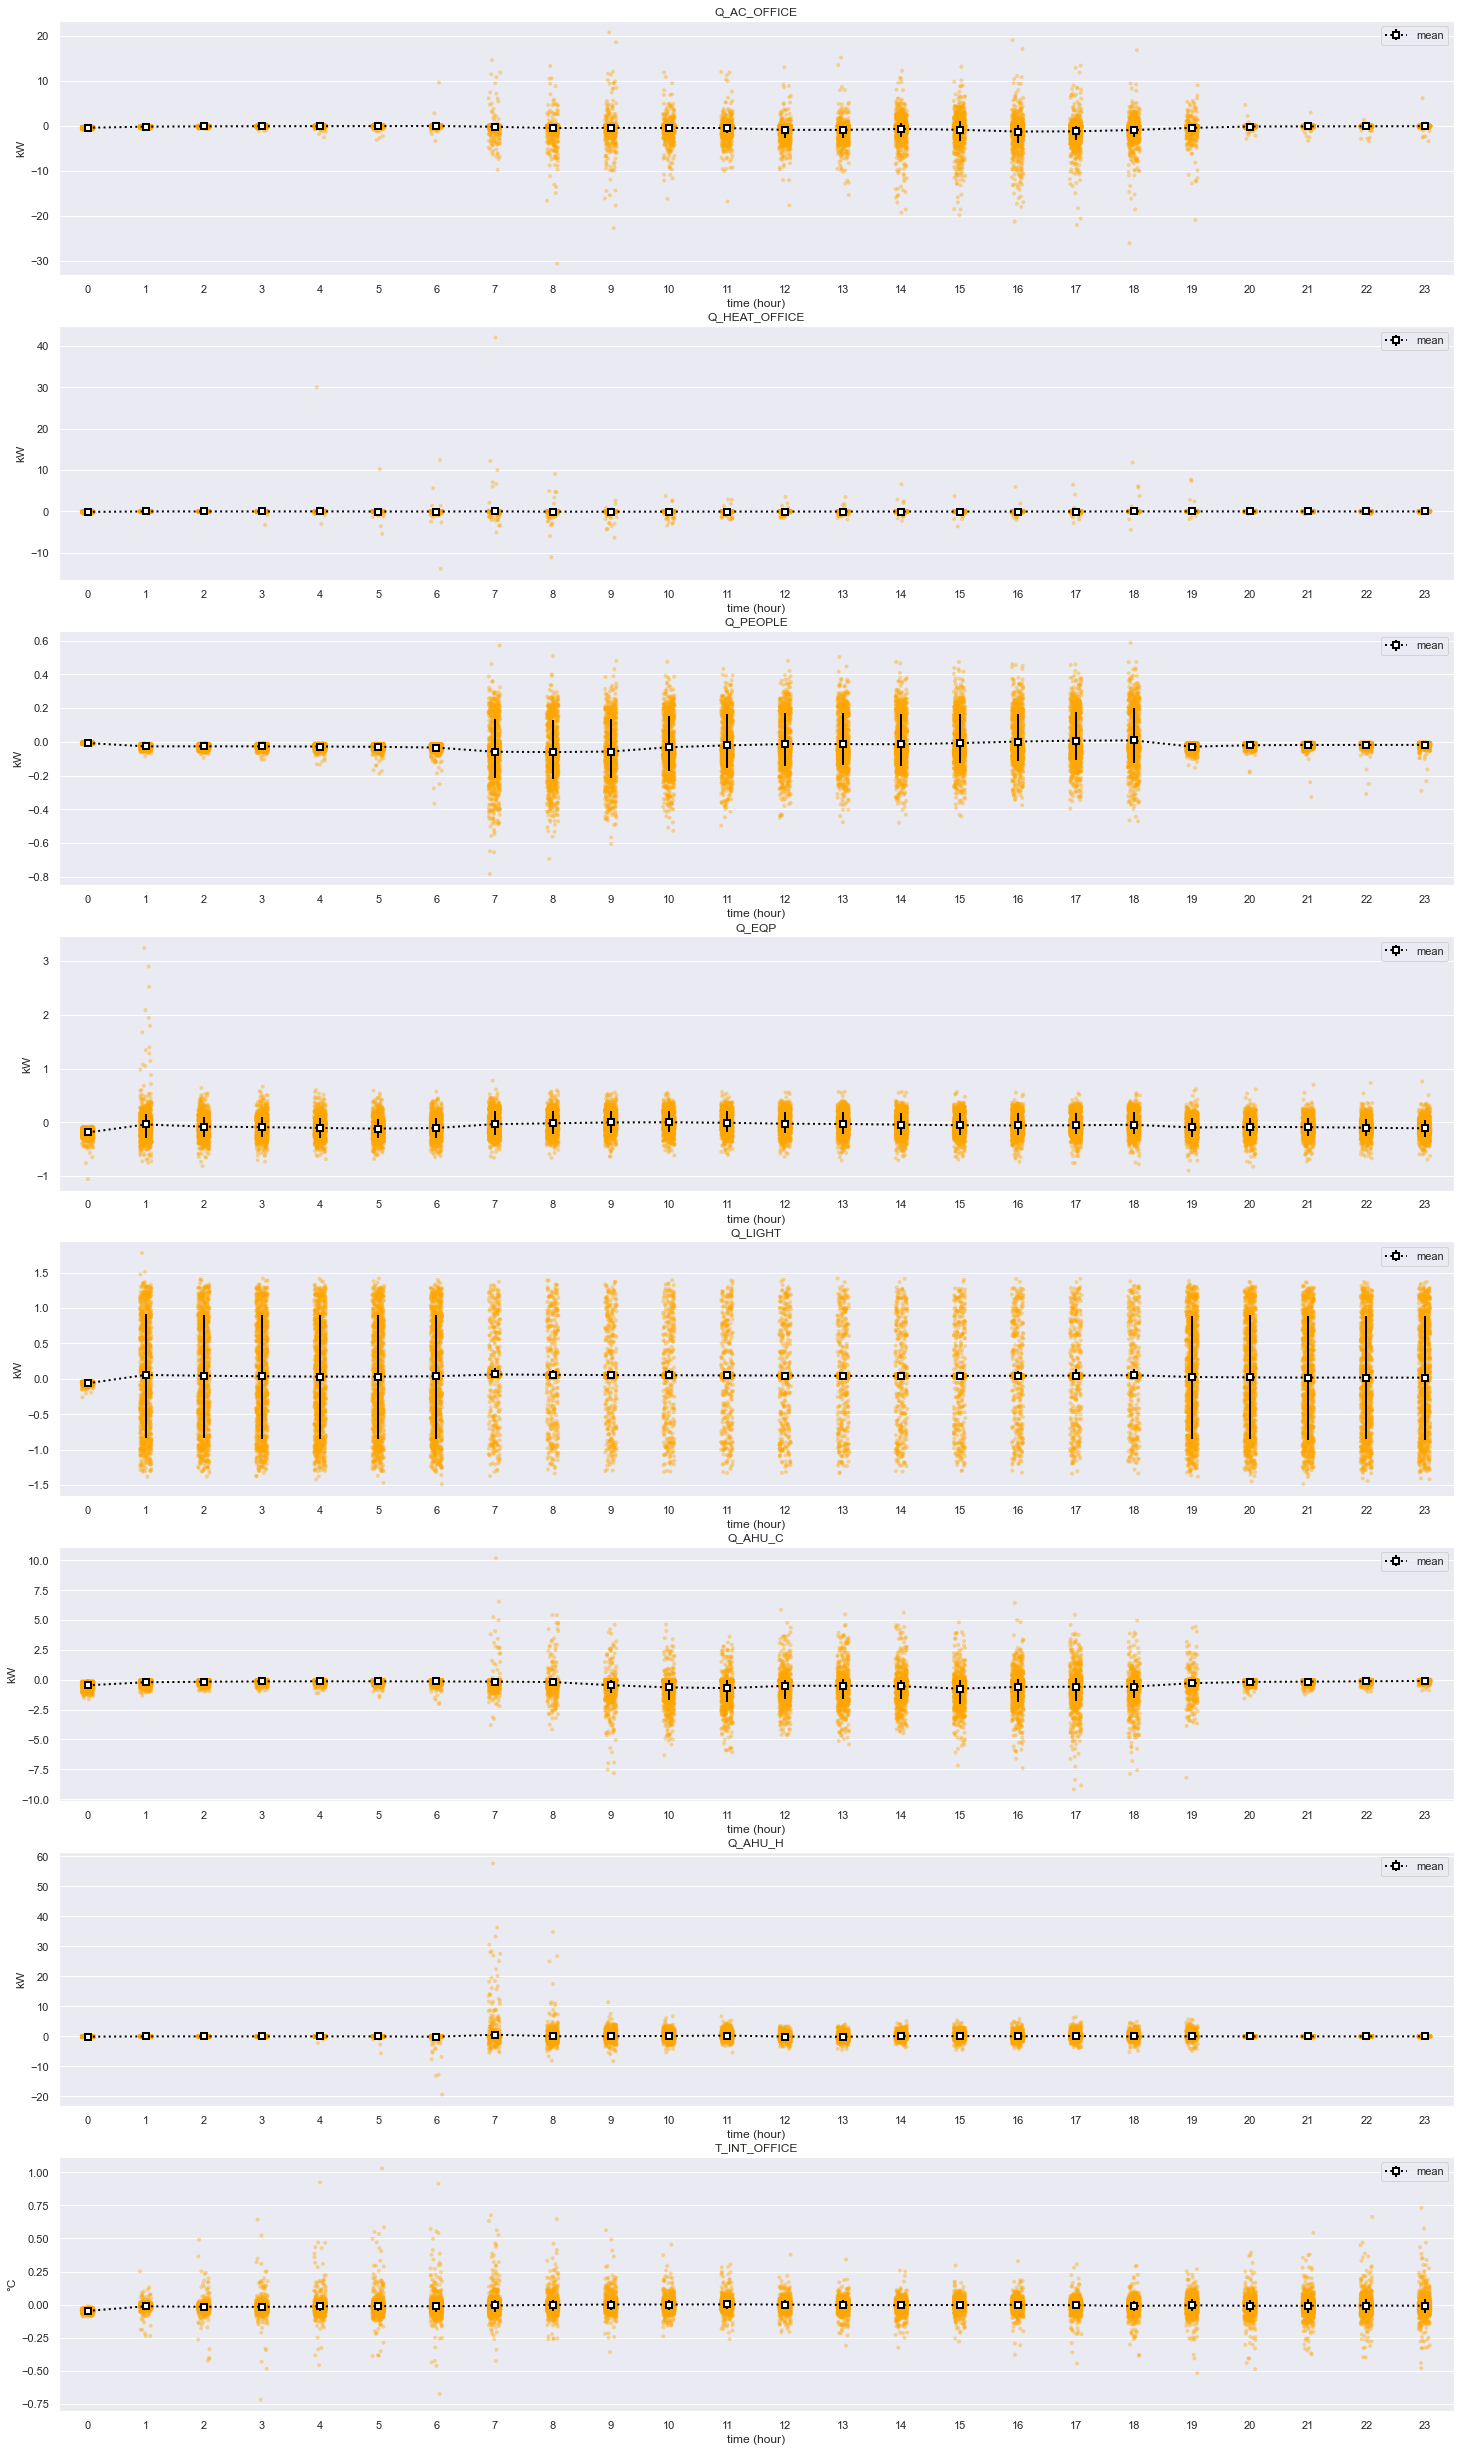

In [28]:
map_plot_function(ozeDataset, predictions, plot_error_distribution,
                  dataset_indices=dataloader_test.dataset.indices, time_limit=24)

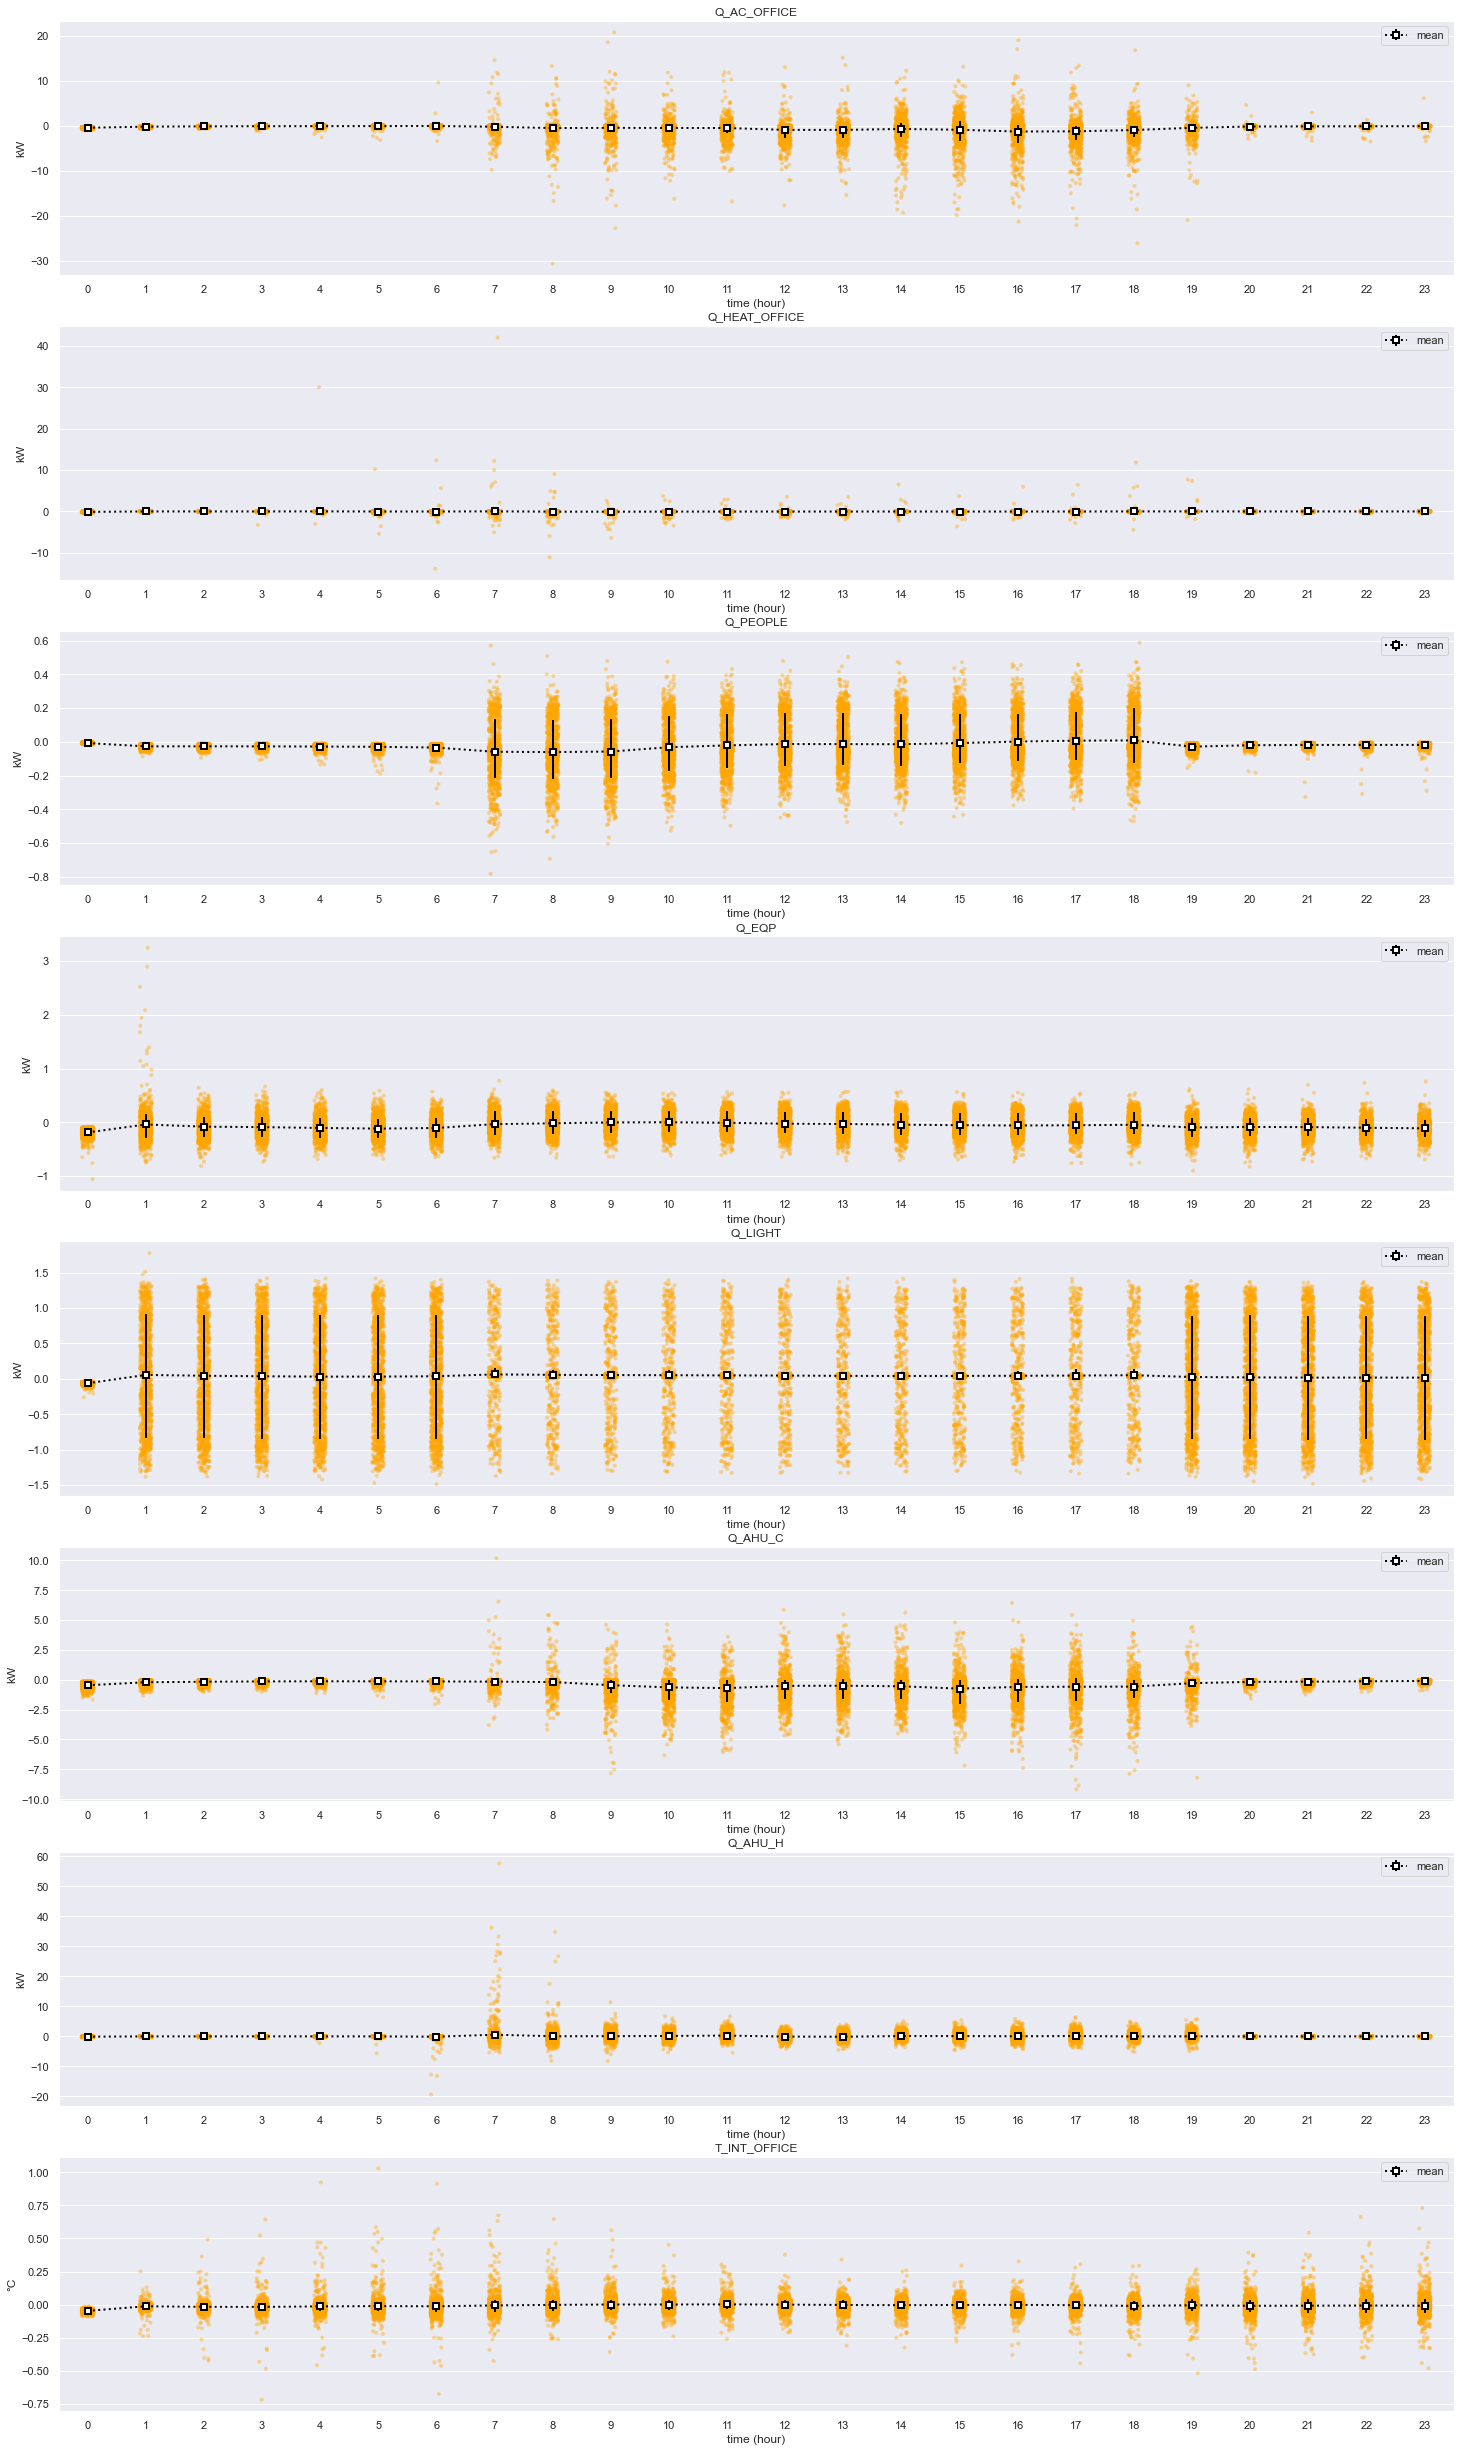

In [29]:
map_plot_function(ozeDataset, predictions, plot_error_distribution, dataset_indices=dataloader_test.dataset.indices, time_limit=24)

### Plot mispredictions thresholds

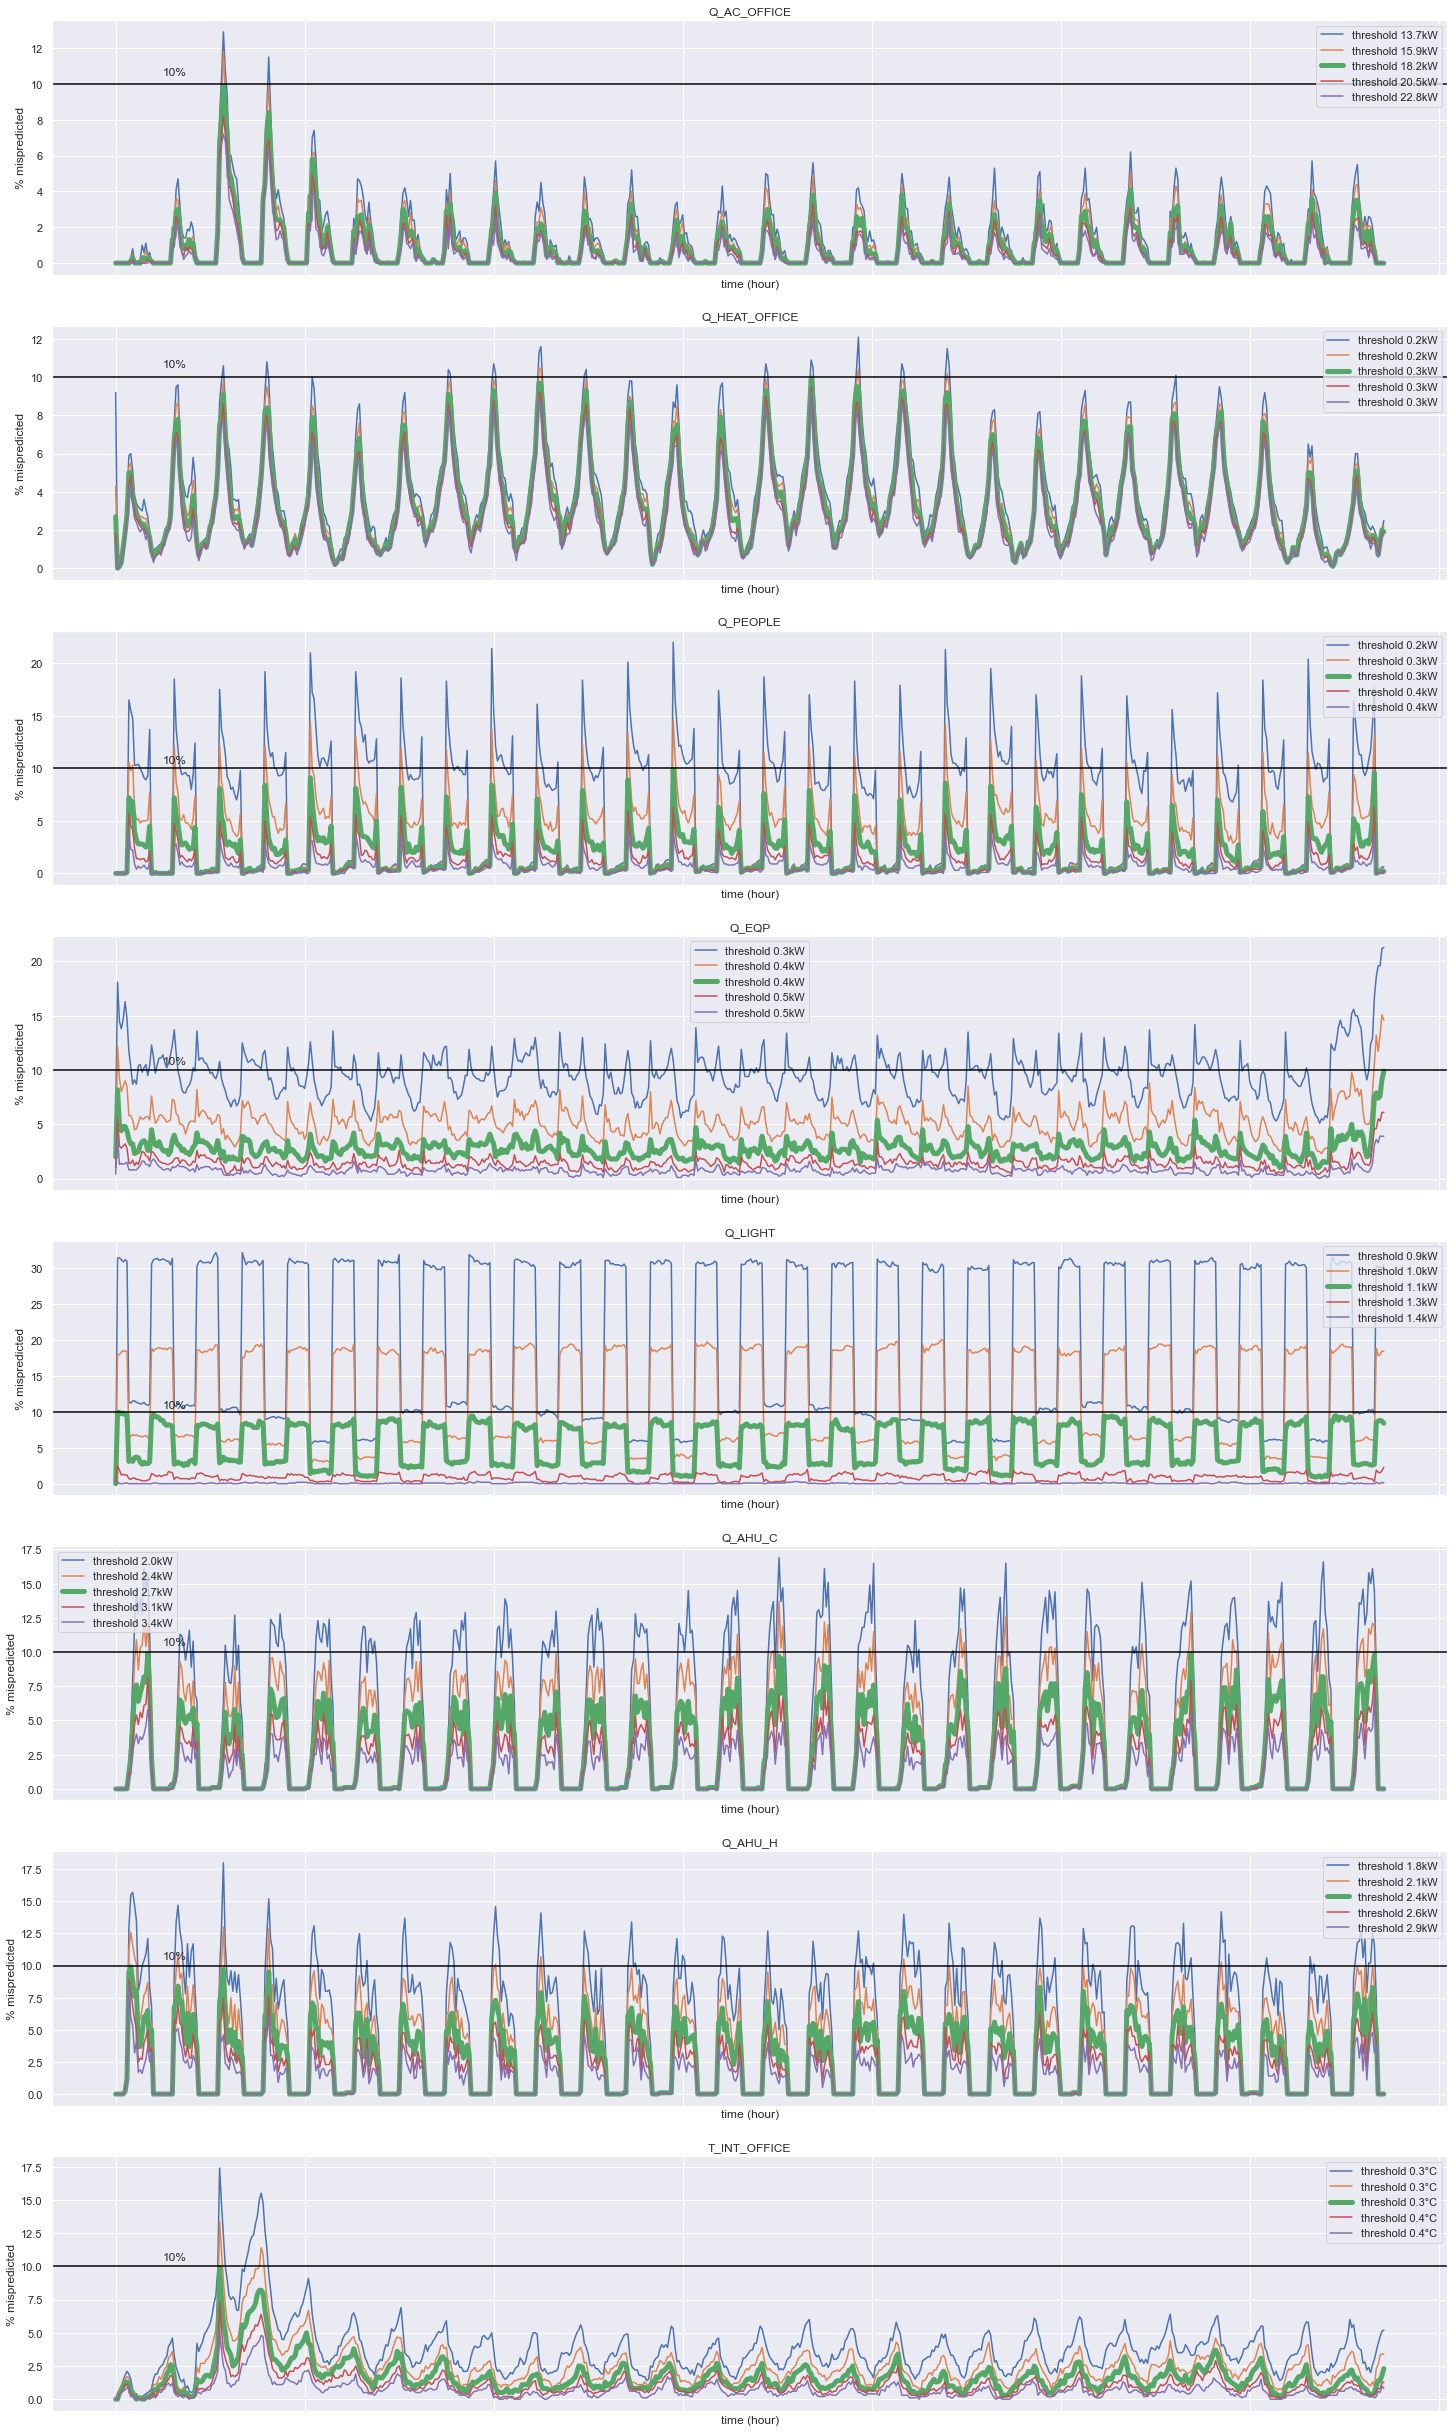

In [30]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, 
                  plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)

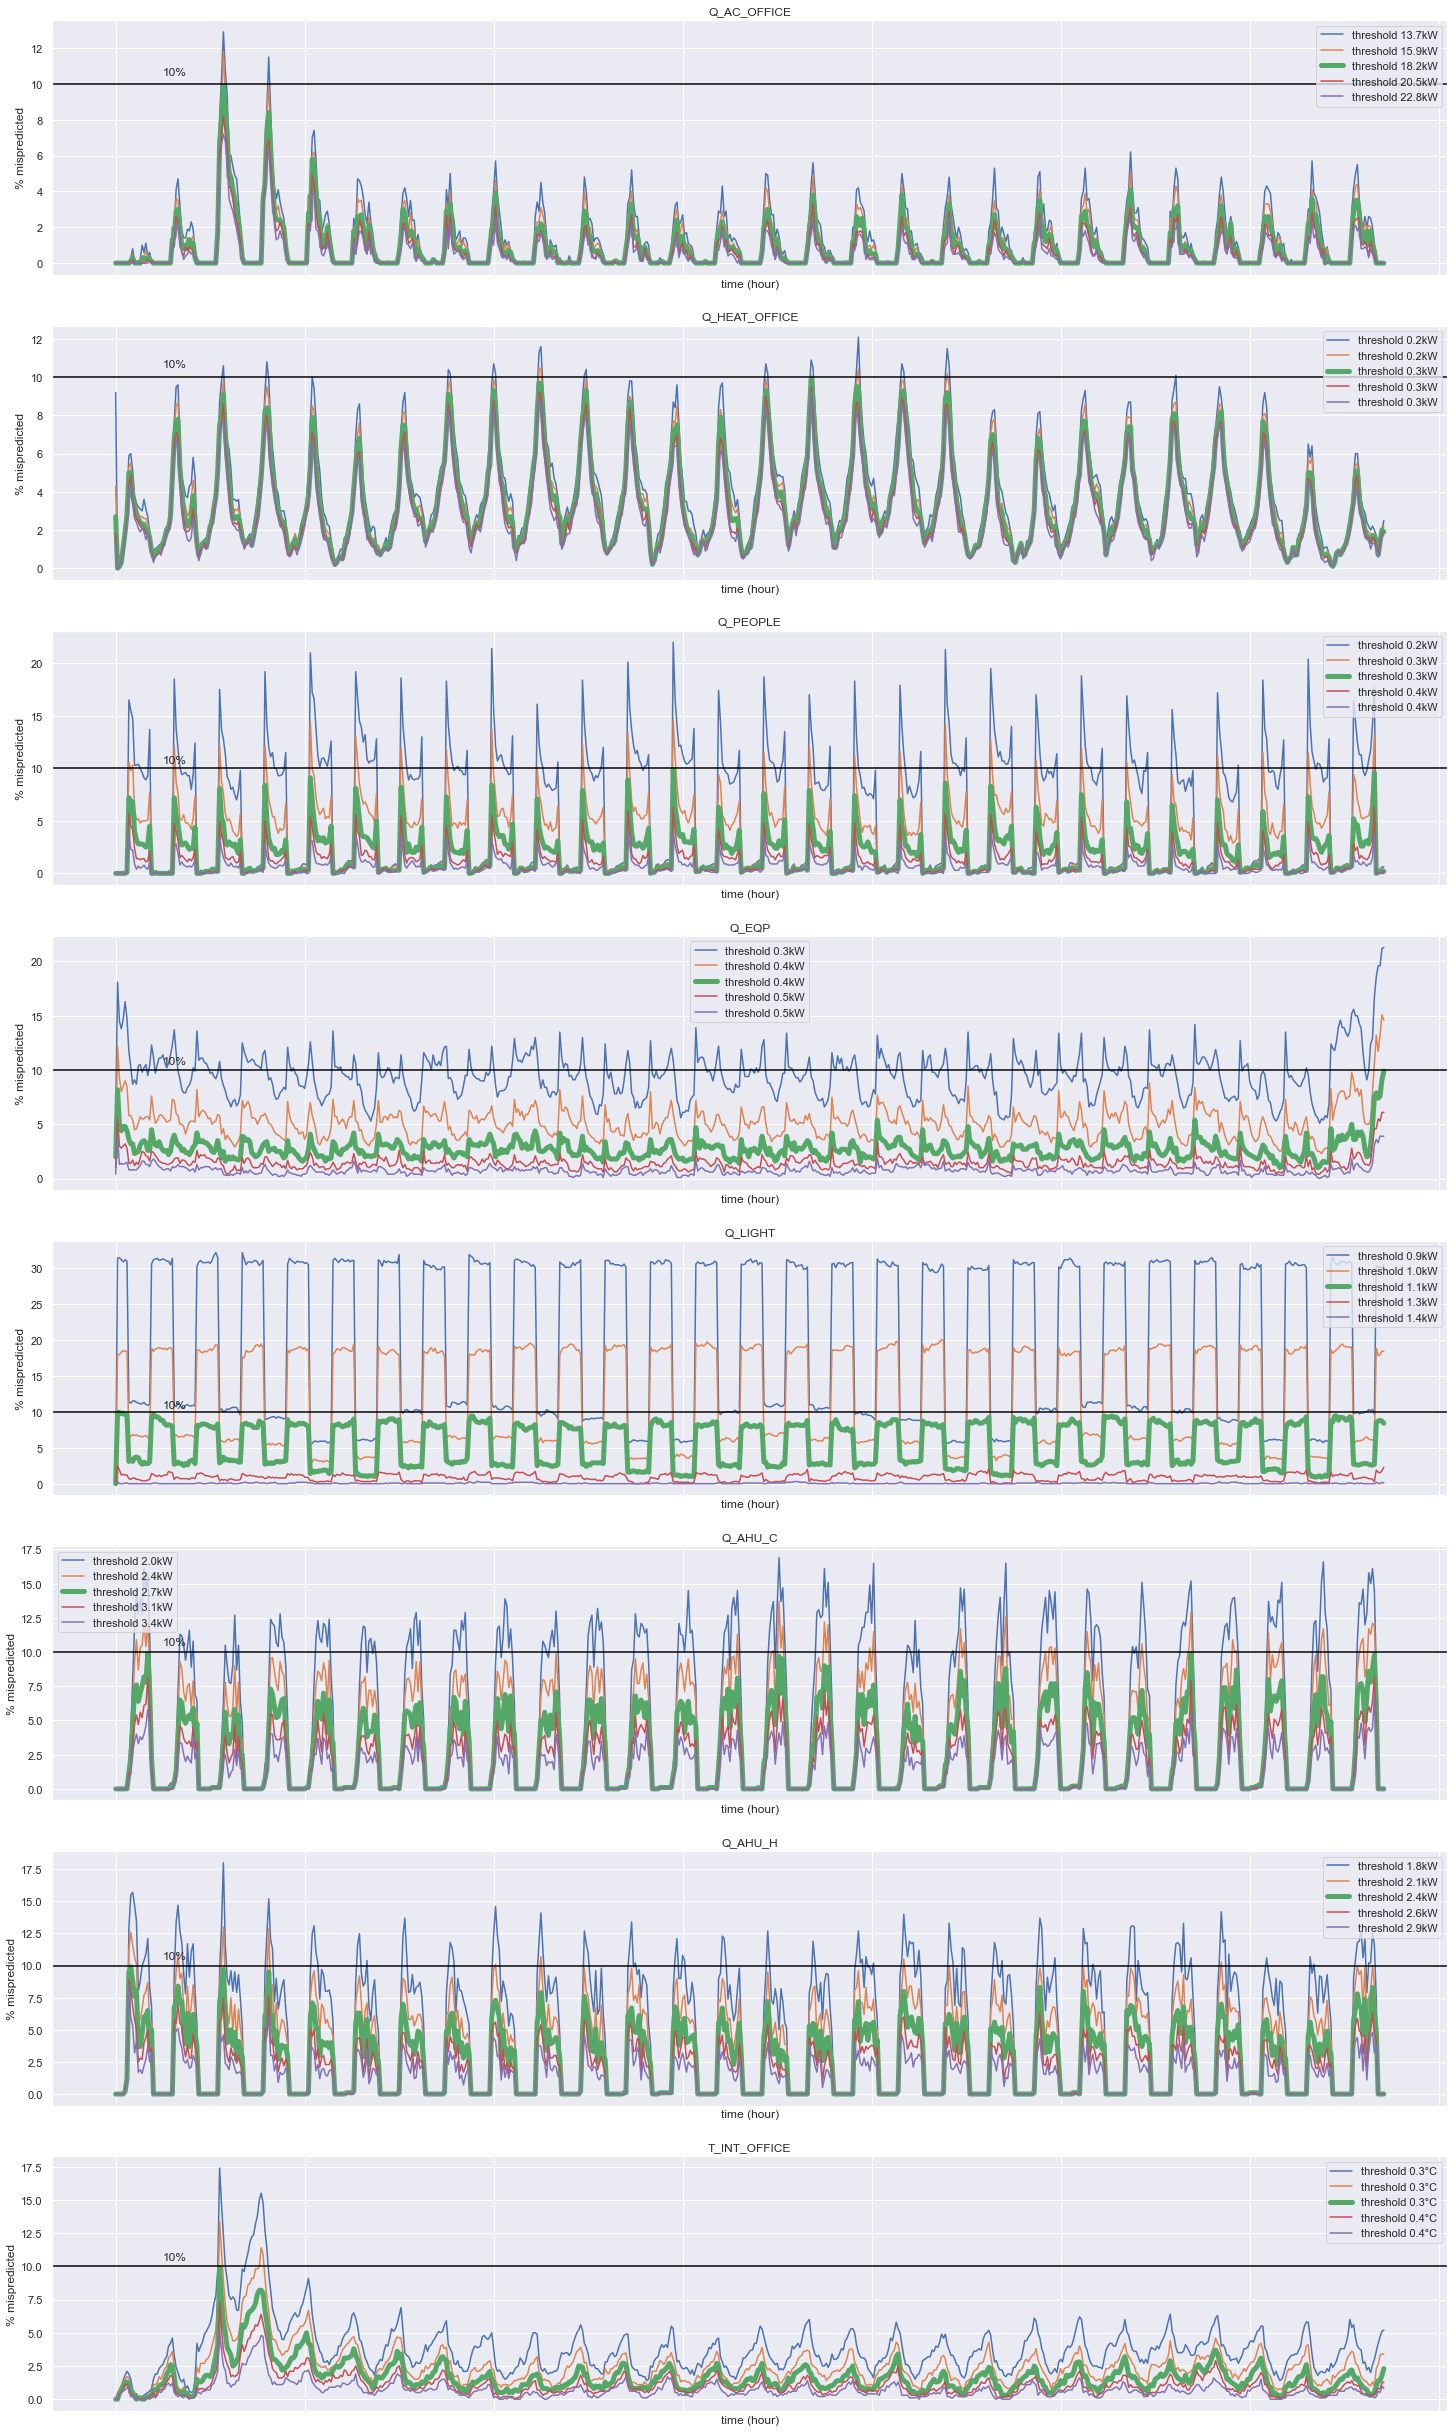

In [31]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)